# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import ast 
import re

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None
from sklearn import set_config
set_config(transform_output='pandas')

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
general_demographics = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

general_demographics.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [7]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [8]:
print(f"The shape of general demographics dataframe is {general_demographics.shape}")
print(f"The shape of features summary dataframe is {feat_info.shape}")

The shape of general demographics dataframe is (891221, 85)
The shape of features summary dataframe is (85, 4)


In [9]:
general_demographics.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
def safe_eval(val):
    try:
        if isinstance(val, str) and val.startswith("["):
            # Ensure values like XX (without quotes) are treated as strings
            val = re.sub(r"(?<=\[|,)\s*([A-Za-z]+)\s*(?=,|\])", r"'\1'", val)
            return ast.literal_eval(val)
        elif isinstance(val, str):
            return [val]  # Convert single string values into lists
        else:
            return []
    except (ValueError, SyntaxError):
        return []

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info["missing_or_unknown"] = feat_info["missing_or_unknown"].apply(safe_eval)
missing_values_dict = dict(zip(feat_info["attribute"], feat_info["missing_or_unknown"]))

In [14]:
for col, missing_vals in missing_values_dict.items():
    general_demographics[col] = general_demographics[col].replace(missing_vals, np.nan)

In [18]:
print(f'Total number of missing values in the general demographics dataset is {general_demographics.isna().sum().sum()}')

Total number of missing values in the general demographics dataset is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_counts = general_demographics.isnull().sum()  
missing_counts

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

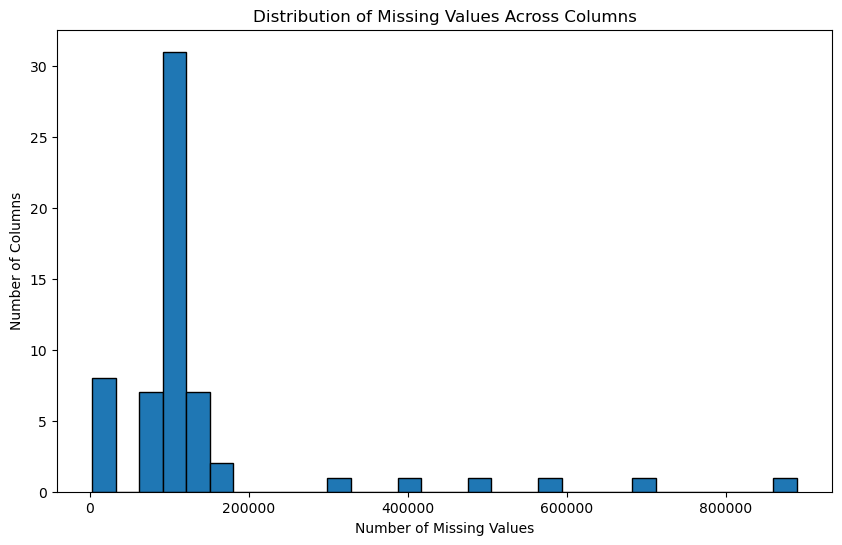

In [21]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(10, 6))
plt.hist(missing_counts[missing_counts > 0], bins=30, edgecolor='black')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of Missing Values Across Columns')
plt.show()

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outlier_columns = (missing_counts[missing_counts >= 200000]).index.tolist()
outlier_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [23]:
general_demographics.drop(columns=outlier_columns, inplace=True)

In [24]:
rows_to_drop = feat_info[feat_info['attribute'].map(lambda x: x in outlier_columns)].index
feat_info.drop(rows_to_drop, inplace=True)

In [28]:
200000 / len(general_demographics)

0.22441122908908115

#### Discussion 1.1.2: Assess Missing Data in Each Column

The distribution of missing values was visualized using a histogram, showing that most columns had fewer than 200,000 (roughly 22%) missing values, while six outliers ('AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX') had over this number of missing values, so based on our findings, we removed the three outlier columns due to their high proportion of missing data. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

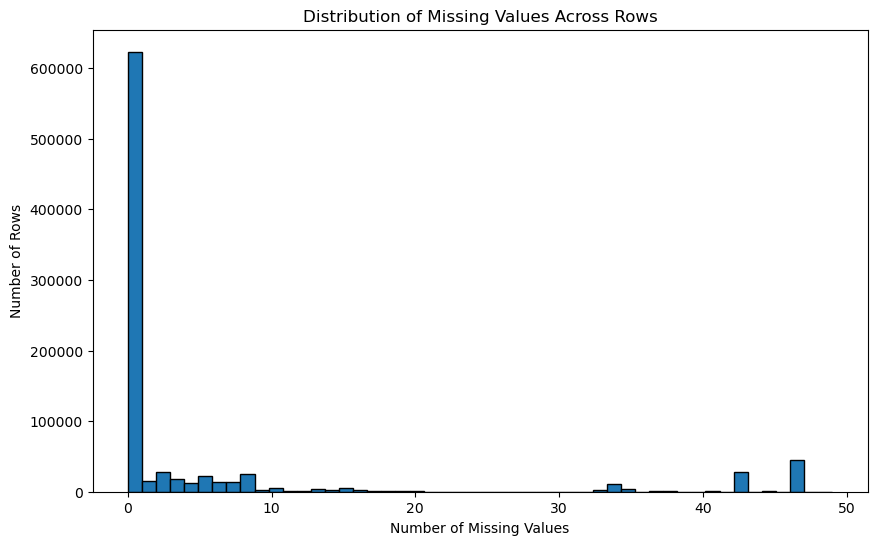

In [32]:
# How much data is missing in each row of the dataset?

general_demographics['missing_count'] = general_demographics.isnull().sum(axis=1)

plt.figure(figsize=(10, 6))
plt.hist(general_demographics['missing_count'], bins=50, edgecolor='black')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values Across Rows')
plt.show()

In [34]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 13

demographics_low_missing = general_demographics[general_demographics['missing_count'] < threshold].drop(columns=['missing_count'])  
demographics_high_missing = general_demographics[general_demographics['missing_count'] >= threshold].drop(columns=['missing_count'])
print(f"Low-missing subset: {demographics_low_missing.shape}")
print(f"High-missing subset: {demographics_high_missing.shape}")

Low-missing subset: (782046, 79)
High-missing subset: (109175, 79)


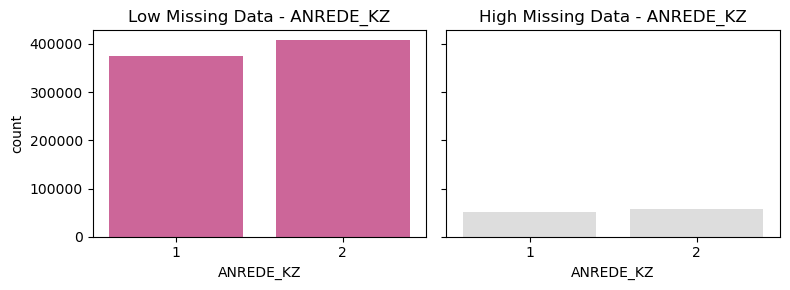

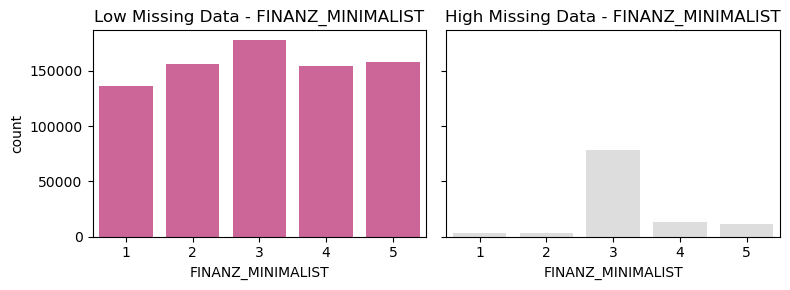

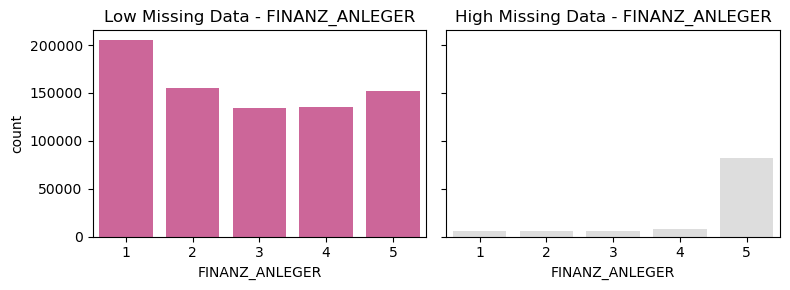

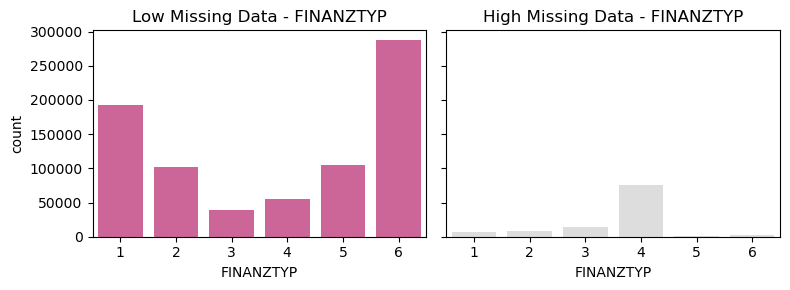

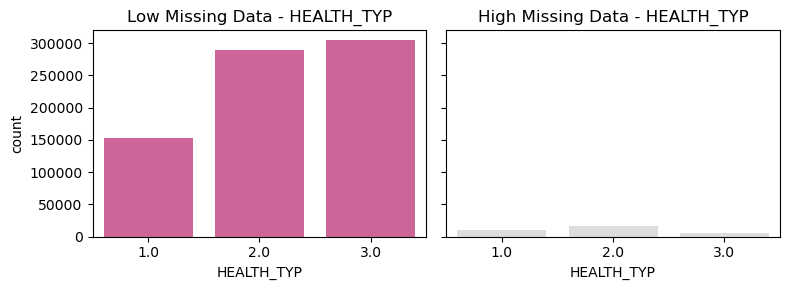

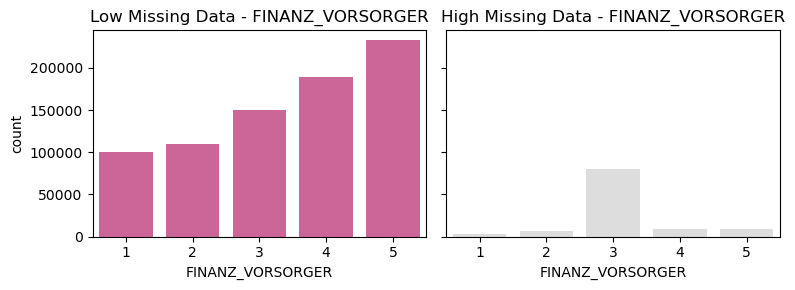

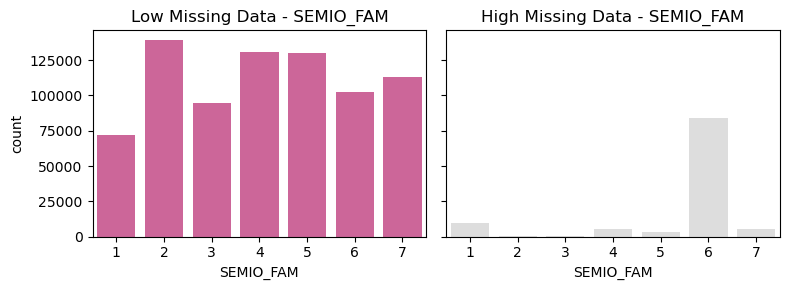

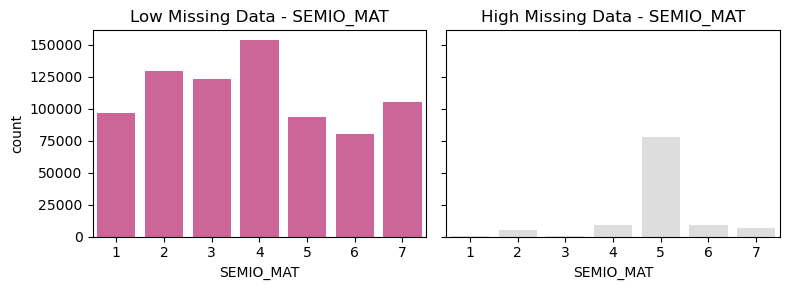

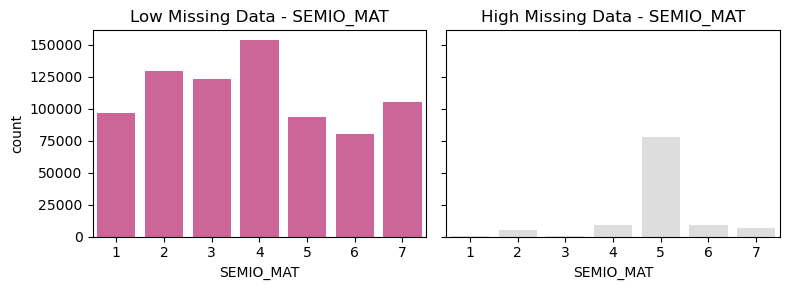

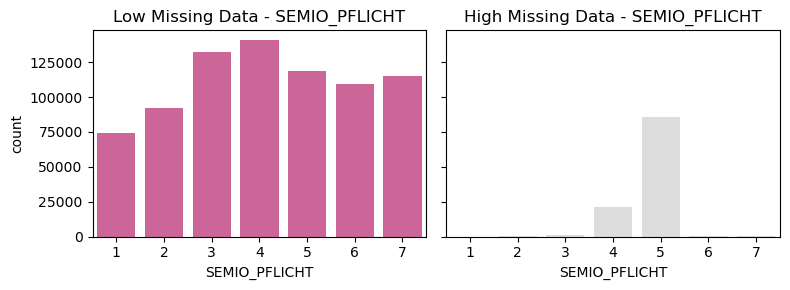

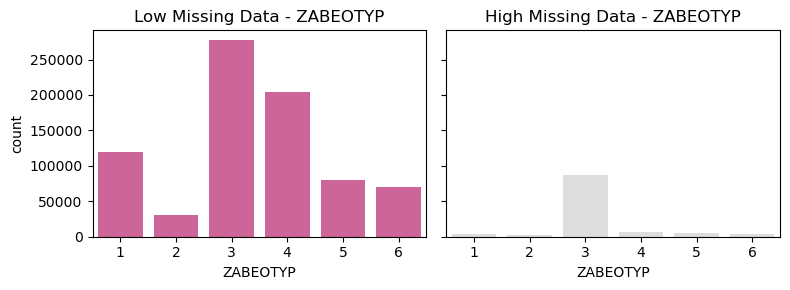

In [38]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

columns_with_no_missing_values = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_ANLEGER', 'FINANZTYP', 'HEALTH_TYP', 'FINANZ_VORSORGER', 'SEMIO_FAM',
                                 'SEMIO_MAT', 'SEMIO_MAT', 'SEMIO_PFLICHT', 'ZABEOTYP']

def compare_distributions(demographics_low, demographics_high, column):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    
    # Plot distribution for rows with few missing values
    sns.countplot(x=demographics_low[column], ax=axes[0], color='#dd5599')
    axes[0].set_title(f'Low Missing Data - {column}')
    axes[0].set_xlabel(column)
    
    # Plot distribution for rows with many missing values
    sns.countplot(x=demographics_high[column], ax=axes[1], color='#dddddd')
    axes[1].set_title(f'High Missing Data - {column}')
    axes[1].set_xlabel(column)
    
    plt.tight_layout()
    plt.show()

for col in columns_with_no_missing_values:
    compare_distributions(demographics_low_missing, demographics_high_missing, col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The distributions of the chosen features in the high-missing dataset are noticeably different from those in the low-missing dataset. This suggests that the rows with many missing values do not just represent random omissions but belong to a qualitatively different subgroup of the data.


this imlplicates the following: 
* Dropping high-missing rows could impact representativeness – since they seem to belong to a distinct segment, their exclusion might introduce bias.
* These missing values are likely not missing at random (MNAR) – instead, they could be related to specific characteristics of the dataset (e.g., different demographic or financial groups).
* Further investigation may be needed – we should document these missing patterns and possibly consider an imputation strategy instead of complete removal.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [45]:
# How many features are there of each data type?

categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute']
ordinal_features = feat_info[feat_info['type'] == 'ordinal']['attribute']
interval_features = feat_info[feat_info['type'] == 'interval']['attribute']
numeric_features = feat_info[feat_info['type'] == 'numeric']['attribute'] 
mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute']

print(f'There are {len(categorical_features)} categorical features in the general demographics dataset, {len(ordinal_features)} ordinal, {len(numeric_features)} numeric, {len(interval_features)} interval and {len(mixed_features)} mixed.')

There are 18 categorical features in the general demographics dataset, 49 ordinal, 6 numeric, 0 interval and 6 mixed.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [47]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

for categorical_feature in categorical_features:
    unique_values = demographics_low_missing[categorical_feature].dropna().unique()
    number_of_unique_values = len(unique_values)
    print(f'{categorical_feature} has ({number_of_unique_values}) different values and they are: {unique_values}, and their data type is [{demographics_low_missing[categorical_feature].dtype}]')

ANREDE_KZ has (2) different values and they are: [2 1], and their data type is [int64]
CJT_GESAMTTYP has (6) different values and they are: [5. 3. 2. 4. 1. 6.], and their data type is [float64]
FINANZTYP has (6) different values and they are: [1 6 5 2 4 3], and their data type is [int64]
GFK_URLAUBERTYP has (12) different values and they are: [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6.], and their data type is [float64]
GREEN_AVANTGARDE has (2) different values and they are: [0 1], and their data type is [int64]
LP_FAMILIE_FEIN has (11) different values and they are: [ 5.  1. 10.  2.  7. 11.  8.  4.  6.  9.  3.], and their data type is [float64]
LP_FAMILIE_GROB has (5) different values and they are: [3. 1. 5. 2. 4.], and their data type is [float64]
LP_STATUS_FEIN has (10) different values and they are: [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7.], and their data type is [float64]
LP_STATUS_GROB has (5) different values and they are: [1. 2. 4. 5. 3.], and their data type is [float64]

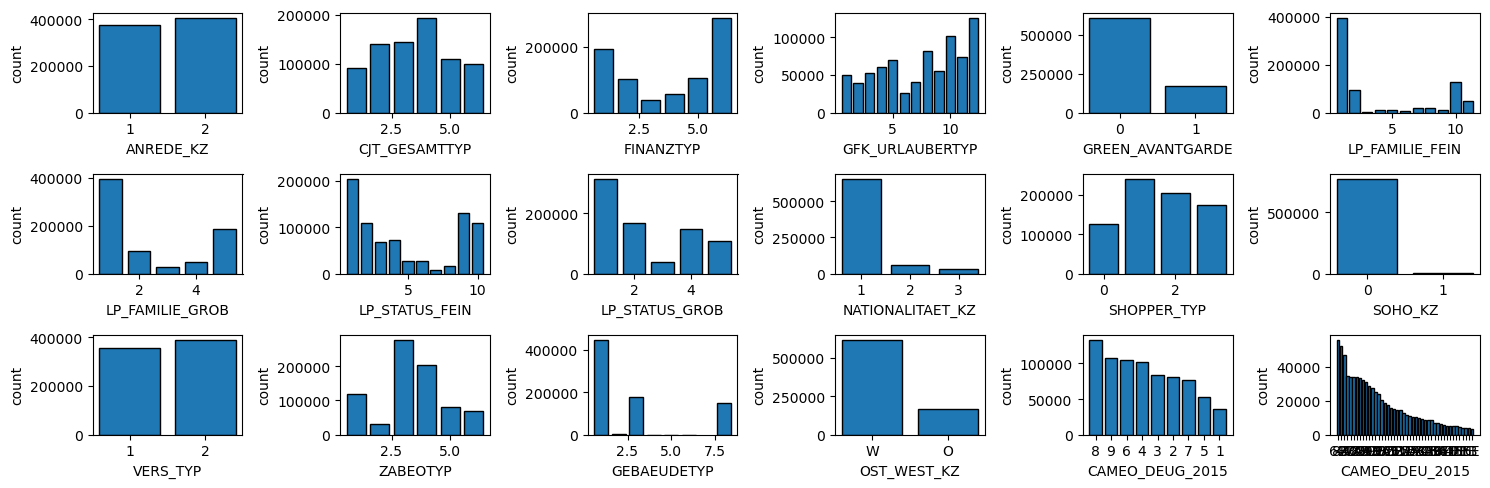

In [49]:
fig, axes = plt.subplots(3, 6, figsize=(15, 5))
i = 0
j = 0
for column in categorical_features:
    axes[i][j].bar(demographics_low_missing[column].value_counts().index, demographics_low_missing[column].value_counts().values, edgecolor='black')
    axes[i][j].set_xlabel(column)
    axes[i][j].set_ylabel('count')
    j += 1
    if j == 6:
        j = 0
        i += 1
    if i == 4:
        break
plt.tight_layout()
plt.show()

In [50]:
columns_to_drop = ['SOHO_KZ', 'CAMEO_DEU_2015']
demographics_low_missing.drop(columns=columns_to_drop, inplace=True)

In [51]:
rows_to_drop = feat_info[feat_info['attribute'].map(lambda x: x in columns_to_drop)].index
feat_info.drop(rows_to_drop, inplace=True)

In [52]:
demographics_low_missing['CAMEO_DEUG_2015'] = demographics_low_missing['CAMEO_DEUG_2015'].astype('Int64')

In [53]:
# Re-encode categorical variable(s) to be kept in the analysis.

remaining_cat_cols = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
remaining_cat_cols.remove('ANREDE_KZ')
remaining_cat_cols.remove('VERS_TYP')
remaining_cat_cols.remove('GREEN_AVANTGARDE') 
remaining_cat_cols

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015']

In [54]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(demographics_low_missing[remaining_cat_cols])
encoded.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_nan
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [55]:
demographics_low_missing_encoded = pd.concat([demographics_low_missing.drop(columns=remaining_cat_cols) ,encoded], axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

I have dropped two columns: ['SOHO_KZ', 'CAMEO_DEU_2015'], where the first one appeared not to have an impact on disciminating the data, since one class appeared to dominate the other, as shown in the plotted histograms. For the second one, it has too many classes and thus was removed. All other categorical columns were kept for further analysis.

Since these are categorical variables, I used one hot encoding to convert them into numeric values.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [58]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Define mappings
decade_mapping = {
    1: 1940, 2: 1940,
    3: 1950, 4: 1950,
    5: 1960, 6: 1960, 7: 1960,
    8: 1970, 9: 1970, 
    10: 1980, 11: 1980, 12: 1980, 13: 1980,
    14: 1990, 15: 1990
}

movement_mapping = {
    1: 0, 2: 1, 
    3: 0, 4: 1,  
    5: 0, 6: 1, 7: 1, 
    8: 0, 9: 1,  
    10: 0, 11: 1, 12: 0, 13: 1, 
    14: 0, 15: 1  
}

demographics_low_missing_encoded["Decade"] = demographics_low_missing_encoded["PRAEGENDE_JUGENDJAHRE"].map(decade_mapping)
demographics_low_missing_encoded["Movement"] = demographics_low_missing_encoded["PRAEGENDE_JUGENDJAHRE"].map(movement_mapping)

print(demographics_low_missing_encoded[["PRAEGENDE_JUGENDJAHRE", "Decade", "Movement"]].head())

   PRAEGENDE_JUGENDJAHRE  Decade  Movement
1                   14.0  1990.0       0.0
2                   15.0  1990.0       1.0
3                    8.0  1970.0       0.0
4                    8.0  1970.0       0.0
5                    3.0  1950.0       0.0


In [59]:
demographics_low_missing_encoded.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)

In [60]:
new_mixed_features = []
new_mixed_features.append('Decade')
new_mixed_features.append('Movement')

In [61]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.    

demographics_low_missing_encoded["CAMEO_INTL_2015"] = demographics_low_missing_encoded["CAMEO_INTL_2015"].astype(str)
demographics_low_missing_encoded["CAMEO_INTL_2015"] = demographics_low_missing_encoded["CAMEO_INTL_2015"].map(lambda x: 66 if x == 'nan' else x)
  
# Extract the first digit as Wealth Category
demographics_low_missing_encoded["CAMEO_Wealth"] = demographics_low_missing_encoded["CAMEO_INTL_2015"].str[0].astype(float)

# Extract the second digit as Life Stage
demographics_low_missing_encoded["CAMEO_LifeStage"] = demographics_low_missing_encoded["CAMEO_INTL_2015"].str[1].astype(float)

In [62]:
demographics_low_missing_encoded["CAMEO_Wealth"] = demographics_low_missing_encoded["CAMEO_Wealth"].map(lambda x: np.nan if x == 6 else x)
demographics_low_missing_encoded["CAMEO_LifeStage"] = demographics_low_missing_encoded["CAMEO_LifeStage"].map(lambda x: np.nan if x == 6 else x)

In [63]:
demographics_low_missing_encoded.drop(columns=["CAMEO_INTL_2015"], inplace=True)

In [64]:
new_mixed_features.append('CAMEO_Wealth')
new_mixed_features.append('CAMEO_LifeStage')

In [65]:
# for LP_LEBENSPHASE_FEIN, divide it to the income level and life stage separately:

# Mapping for Income Level
income_mapping = {
    1: "low", 2: "low", 5: "low", 6: "low",
    14: "low", 15: "low", 21: "low", 24: "low",
    29: "low", 31: "low",
    
    3: "average", 4: "average", 7: "average", 8: "average",
    16: "average", 22: "average", 25: "average",
    30: "average", 32: "average",
    
    9: "independent", 17: "independent", 26: "independent",
    33: "independent", 36: "independent",
    
    10: "wealthy", 12: "wealthy", 18: "wealthy", 20: "wealthy",
    27: "wealthy", 34: "wealthy", 37: "wealthy", 38: "wealthy",
    
    11: "homeowner", 19: "homeowner", 23: "homeowner",
    28: "homeowner", 35: "homeowner",
    
    13: "top_earner", 23: "top_earner", 28: "top_earner",
    35: "top_earner", 39: "top_earner", 40: "top_earner"
}

# Mapping for Life Stage
life_stage_mapping = {
    1: "young", 3: "young", 14: "young", 18: "young",
    29: "young", 30: "young", 33: "young", 34: "young", 35: "young",
    
    2: "middle", 4: "middle", 13: "middle", 15: "middle",
    39: "middle",
    
    5: "advanced", 7: "advanced", 11: "advanced",
    16: "advanced", 19: "advanced", 31: "advanced",
    36: "advanced", 37: "advanced",
    
    6: "retirement", 8: "retirement", 10: "retirement",
    12: "retirement", 20: "retirement", 23: "retirement",
    28: "retirement", 38: "retirement", 40: "retirement"
}

demographics_low_missing_encoded["LP_Income"] = demographics_low_missing_encoded["LP_LEBENSPHASE_FEIN"].map(income_mapping)
demographics_low_missing_encoded["LP_LifeStage"] = demographics_low_missing_encoded["LP_LEBENSPHASE_FEIN"].map(life_stage_mapping)

demographics_low_missing_encoded.drop(columns=["LP_LEBENSPHASE_FEIN"], inplace=True)

In [66]:
LP_Income_mapping = {
    "low": 0, "average": 1, "independent": 2, "wealthy": 3, "homeowner": 4, "top_earner": 5
}

LP_LifeStage_mapping = {
    "young": 0, "middle": 1, "advanced": 2, "retirement": 3
}

demographics_low_missing_encoded["LP_Income"] = demographics_low_missing_encoded["LP_Income"].map(LP_Income_mapping).astype(float)
demographics_low_missing_encoded["LP_LifeStage"] = demographics_low_missing_encoded["LP_LifeStage"].map(LP_LifeStage_mapping).astype(float)

In [67]:
new_mixed_features.append('LP_Income')
new_mixed_features.append('LP_LifeStage')

In [68]:
# for LP_LEBENSPHASE_GROB, break it down into income level and life stage:

# Mapping for Income Level
income_mapping_grob = {
    1: "low_average", 2: "low_average", 4: "low_average",
    7: "low_average", 9: "low_average", 10: "low_average",
    
    3: "high", 5: "high", 8: "high",
    11: "high", 12: "high",
}

# Mapping for Life Stage
life_stage_mapping_grob = {
    1: "young", 9: "young", 11: "young",
    
    2: "higher_age", 10: "higher_age", 12: "higher_age",
    
    3: "single", 4: "couple", 5: "couple",
    
    6: "single_parent",
    
    7: "family", 8: "family"
}

demographics_low_missing_encoded["LP_Income_Grob"] = demographics_low_missing_encoded["LP_LEBENSPHASE_GROB"].map(income_mapping_grob)
demographics_low_missing_encoded["LP_LifeStage_Grob"] = demographics_low_missing_encoded["LP_LEBENSPHASE_GROB"].map(life_stage_mapping_grob)
demographics_low_missing_encoded.drop(columns=["LP_LEBENSPHASE_GROB"], inplace=True)

In [69]:
LP_Income_Grob_mapping = {
    "low_average": 0, "high": 1
}

LP_LifeStage_Grob_mapping = {
    "young": 0, "higher_age": 1, "single": 2, "couple": 3, "single_parent": 4, "family": 5
}

demographics_low_missing_encoded["LP_Income_Grob"] = demographics_low_missing_encoded["LP_Income_Grob"].map(LP_Income_Grob_mapping)
demographics_low_missing_encoded["LP_LifeStage_Grob"] = demographics_low_missing_encoded["LP_LifeStage_Grob"].map(LP_LifeStage_Grob_mapping)

In [70]:
new_mixed_features.append('LP_Income_Grob')
new_mixed_features.append('LP_LifeStage_Grob')

#### Discussion 1.2.2: Engineer Mixed-Type Features

I have engineered four features: LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 as they seemed to give different information that might be essential for model learning, these engineering steps involved breaking them down to their component features and then dropping them from the dataset. I have not done any engineering processes on the rest of mixed features as I did not see there was a need to do so. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [73]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

demographics_low_missing_encoded.dtypes

ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT                  int64
SEMIO_KRIT                 int64
SEMIO_DOM                  int64
SEMIO_KAEM                 int64
SEMIO_PFLICHT              int64
SEMIO_TRADV                int64
VERS_TYP                 float64
ANZ_PERSONEN             float64
ANZ_TITEL                float64
HH_EINKOMMEN_SCORE       float64
W_KEIT_KIND_HH           float64
WOHNDAUER_

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [75]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col, missing_vals in missing_values_dict.items():
        df[col] = df[col].replace(missing_vals, np.nan)
    
    # remove selected columns and rows, ...
    df.drop(columns=outlier_columns, inplace=True)

    threshold = 13
    df['missing_count'] = df.isnull().sum(axis=1)
    df_low_missing = df[df['missing_count'] < threshold].drop(columns=['missing_count'])  
    df_high_missing = df[df['missing_count'] >= threshold].drop(columns=['missing_count'])
    
    # select, re-encode, and engineer column values.
    
    columns_to_drop = ['SOHO_KZ', 'CAMEO_DEU_2015']
    df_low_missing.drop(columns=columns_to_drop, inplace=True)
    
    df_low_missing['CAMEO_DEUG_2015'] = df_low_missing['CAMEO_DEUG_2015'].astype('Int64')
        
    encoded = encoder.transform(df_low_missing[remaining_cat_cols])
    
    df_low_missing_encoded = pd.concat([df_low_missing.drop(columns=remaining_cat_cols) ,encoded], axis=1)

    df_low_missing_encoded["Decade"] = df_low_missing_encoded["PRAEGENDE_JUGENDJAHRE"].map(decade_mapping)
    df_low_missing_encoded["Movement"] = df_low_missing_encoded["PRAEGENDE_JUGENDJAHRE"].map(movement_mapping)
    df_low_missing_encoded.drop(columns=["PRAEGENDE_JUGENDJAHRE"], inplace=True)

    # Extract the first digit as Wealth Category
    df_low_missing_encoded["CAMEO_Wealth"] = df_low_missing_encoded["CAMEO_INTL_2015"].str[0].astype(float)

    # Extract the second digit as Life Stage
    df_low_missing_encoded["CAMEO_LifeStage"] = df_low_missing_encoded["CAMEO_INTL_2015"].str[1].astype(float)

    df_low_missing_encoded["CAMEO_Wealth"] = df_low_missing_encoded["CAMEO_Wealth"].map(lambda x: np.nan if x == 6 else x)
    df_low_missing_encoded["CAMEO_LifeStage"] = df_low_missing_encoded["CAMEO_LifeStage"].map(lambda x: np.nan if x == 6 else x)
    df_low_missing_encoded.drop(columns=["CAMEO_INTL_2015"], inplace=True)

    df_low_missing_encoded["LP_Income"] = df_low_missing_encoded["LP_LEBENSPHASE_FEIN"].map(income_mapping)
    df_low_missing_encoded["LP_LifeStage"] = df_low_missing_encoded["LP_LEBENSPHASE_FEIN"].map(life_stage_mapping)

    df_low_missing_encoded.drop(columns=["LP_LEBENSPHASE_FEIN"], inplace=True)
    df_low_missing_encoded["LP_Income"] = df_low_missing_encoded["LP_Income"].map(LP_Income_mapping).astype(float)
    df_low_missing_encoded["LP_LifeStage"] = df_low_missing_encoded["LP_LifeStage"].map(LP_LifeStage_mapping).astype(float)

    df_low_missing_encoded["LP_Income_Grob"] = df_low_missing_encoded["LP_LEBENSPHASE_GROB"].map(income_mapping_grob)
    df_low_missing_encoded["LP_LifeStage_Grob"] = df_low_missing_encoded["LP_LEBENSPHASE_GROB"].map(life_stage_mapping_grob)
    df_low_missing_encoded.drop(columns=["LP_LEBENSPHASE_GROB"], inplace=True)

    df_low_missing_encoded["LP_Income_Grob"] = df_low_missing_encoded["LP_Income_Grob"].map(LP_Income_Grob_mapping)
    df_low_missing_encoded["LP_LifeStage_Grob"] = df_low_missing_encoded["LP_LifeStage_Grob"].map(LP_LifeStage_Grob_mapping)

    # Return the cleaned dataframe.
    return df_low_missing_encoded

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [80]:
demographics_low_missing_encoded.isna().sum()

ALTERSKATEGORIE_GROB       2685
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
HEALTH_TYP                35117
RETOURTYP_BK_S             4061
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
VERS_TYP                  35117
ANZ_PERSONEN                  0
ANZ_TITEL                     0
HH_EINKOMMEN_SCORE            0
W_KEIT_KIND_HH            57065
WOHNDAUER_2008                0
ANZ_HAUS

In [81]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

impute_median = SimpleImputer(strategy='median')
# Fit the imputer object on the training data with .fit
demographics_low_missing_encoded[numeric_features.tolist()] = impute_median.fit_transform(demographics_low_missing_encoded[numeric_features.tolist()])

impute_mode = SimpleImputer(strategy='most_frequent')
demographics_low_missing_encoded[ordinal_features.tolist() + new_mixed_features + ['VERS_TYP', 'PLZ8_BAUMAX']] = impute_mode.fit_transform(demographics_low_missing_encoded[ordinal_features.tolist() + new_mixed_features + ['VERS_TYP', 'PLZ8_BAUMAX']])

In [99]:
demographics_cleaned = demographics_low_missing_encoded

In [101]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
demographics_cleaned[numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']] = scaler.fit_transform(demographics_cleaned[numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']])

In [103]:
demographics_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_nan,Decade,Movement,CAMEO_Wealth,CAMEO_LifeStage,LP_Income,LP_LifeStage,LP_Income_Grob,LP_LifeStage_Grob
1,1.0,2,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,0.916241,0.230685,-0.060766,6.0,3.0,9.0,0.165190,-0.125701,1.0,-0.392225,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,1.019103,2.0,3.0,2.0,1.0,-0.641880,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1990.0,0.0,5.0,1.0,0.0,2.0,0.0,4.0
2,3.0,2,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,-1.091416,-0.631803,-0.060766,4.0,3.0,9.0,0.101520,-0.125701,5.0,-0.392225,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,0.276919,3.0,3.0,1.0,0.0,-0.641880,4.0,4.0,3.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1990.0,1.0,2.0,4.0,1.0,0.0,0.0,0.0
3,4.0,2,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,

In [105]:
demographics_cleaned.isna().sum().sum()

0

### Discussion 2.1: Apply Feature Scaling

I have imputed the missing data for different column types using Simple Imputer. For numeric columns, I imputed them using the median value in the column, while for ordinal and mixed columns, I used the median to impute the missing values.

I have then scaled the numeric, interval, ordinal and some mixed columns using standard scaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [109]:
# Apply PCA to the data.

from sklearn.decomposition import PCA
pca = PCA()
demographics_pca = pca.fit_transform(demographics_cleaned)

<Figure size 800x600 with 0 Axes>

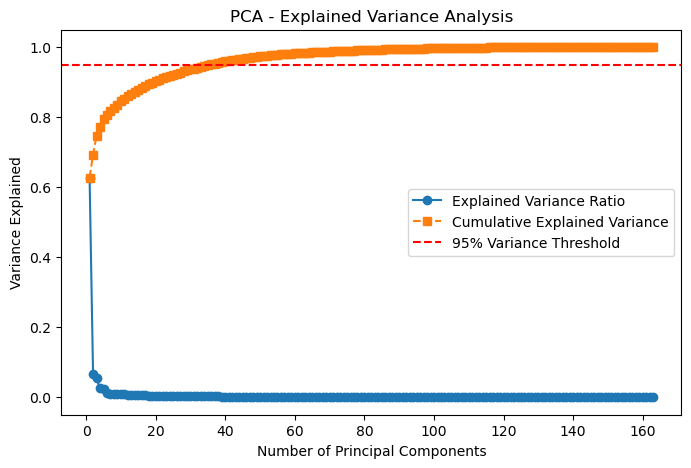

In [111]:
# Investigate the variance accounted for by each principal component.

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label="Explained Variance Ratio")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='--', label="Cumulative Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='dashed', label="95% Variance Threshold")
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.legend()
plt.title("PCA - Explained Variance Analysis")
plt.show()

In [113]:
# Re-apply PCA to the data while selecting for number of components to retain.

n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain (≥95% variance): {n_components}")

pca = PCA(n_components=n_components)
demographics_pca = pca.fit_transform(demographics_cleaned)

Number of components to retain (≥95% variance): 36


### Discussion 2.2: Perform Dimensionality Reduction

- Principal Component Analysis (PCA) was applied to the dataset to identify the directions of maximal variance. 
- The explained variance analysis showed that the cumulative explained variance exceeds 95% at 36 components.
- To balance dimensionality reduction with variance retention, I decided to retain 36 principal components for the next step of the analysis.
- Retaining 36 components preserves approximately 95% of the total variance while reducing the dimensionality, which should help improve clustering performance and reduce noise.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [117]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

feature_names = demographics_cleaned.columns.tolist()
def print_sorted_feature_weights(pca, feature_names, component_index):
    component_weights = pca.components_[component_index]
    
    # Map weights to feature names
    feature_weights = list(zip(feature_names, component_weights))
    
    # Sort by weight (ascending order)
    sorted_weights = sorted(feature_weights, key=lambda x: x[1])
    
    print(f"\nPrincipal Component {component_index + 1}:")
    for feature, weight in sorted_weights:
        print(f"{feature}: {weight:.4f}")

print_sorted_feature_weights(pca, feature_names, 0)


Principal Component 1:
FINANZ_VORSORGER: -0.0717
SEMIO_LUST: -0.0626
SEMIO_ERL: -0.0514
FINANZ_MINIMALIST: -0.0477
ALTERSKATEGORIE_GROB: -0.0448
RETOURTYP_BK_S: -0.0423
LP_LifeStage: -0.0414
W_KEIT_KIND_HH: -0.0354
WOHNDAUER_2008: -0.0286
LP_Income: -0.0241
ZABEOTYP_3: -0.0165
CAMEO_LifeStage: -0.0156
LP_LifeStage_Grob: -0.0125
SEMIO_VERT: -0.0121
FINANZ_HAUSBAUER: -0.0094
MOBI_REGIO: -0.0093
CJT_GESAMTTYP_2.0: -0.0091
KBA05_ANTG1: -0.0086
FINANZTYP_2: -0.0083
SEMIO_KRIT: -0.0081
FINANZTYP_5: -0.0072
LP_Income_Grob: -0.0065
FINANZTYP_6: -0.0063
KBA05_GBZ: -0.0056
SHOPPER_TYP_3.0: -0.0056
INNENSTADT: -0.0055
NATIONALITAET_KZ_1.0: -0.0054
KONSUMNAEHE: -0.0050
CJT_GESAMTTYP_1.0: -0.0048
BALLRAUM: -0.0038
PLZ8_ANTG1: -0.0036
LP_STATUS_FEIN_9.0: -0.0033
LP_STATUS_FEIN_10.0: -0.0032
LP_STATUS_GROB_5.0: -0.0032
LP_FAMILIE_FEIN_2.0: -0.0032
LP_FAMILIE_GROB_2.0: -0.0032
LP_STATUS_FEIN_1.0: -0.0032
GEBAEUDETYP_RASTER: -0.0031
LP_STATUS_GROB_4.0: -0.0030
GFK_URLAUBERTYP_7.0: -0.0024
PLZ8_GBZ: -0

In [119]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_feature_weights(pca, feature_names, 1)


Principal Component 2:
INNENSTADT: -0.2886
BALLRAUM: -0.2658
LP_Income: -0.2260
MOBI_REGIO: -0.2129
KBA05_ANTG1: -0.1906
KONSUMNAEHE: -0.1895
KBA05_GBZ: -0.1849
WOHNLAGE: -0.1789
FINANZ_MINIMALIST: -0.1530
PLZ8_ANTG1: -0.1417
PLZ8_GBZ: -0.1189
CAMEO_LifeStage: -0.1006
ONLINE_AFFINITAET: -0.0964
SEMIO_VERT: -0.0787
GEBAEUDETYP_RASTER: -0.0714
LP_LifeStage_Grob: -0.0682
ANZ_PERSONEN: -0.0597
LP_Income_Grob: -0.0578
KBA13_ANZAHL_PKW: -0.0517
MIN_GEBAEUDEJAHR: -0.0468
WOHNDAUER_2008: -0.0443
LP_STATUS_GROB_4.0: -0.0368
Decade: -0.0358
LP_STATUS_FEIN_9.0: -0.0339
FINANZ_ANLEGER: -0.0329
GEBAEUDETYP_1.0: -0.0308
ZABEOTYP_1: -0.0256
LP_STATUS_FEIN_10.0: -0.0202
LP_STATUS_GROB_5.0: -0.0202
CAMEO_DEUG_2015_4.0: -0.0196
SEMIO_KULT: -0.0189
LP_LifeStage: -0.0188
Movement: -0.0186
GREEN_AVANTGARDE: -0.0186
LP_FAMILIE_GROB_5.0: -0.0181
CAMEO_DEUG_2015_2.0: -0.0179
CAMEO_DEUG_2015_3.0: -0.0154
ALTERSKATEGORIE_GROB: -0.0121
NATIONALITAET_KZ_1.0: -0.0118
FINANZTYP_2: -0.0116
LP_STATUS_FEIN_4.0: -0.01

In [121]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_feature_weights(pca, feature_names, 2)


Principal Component 3:
SEMIO_KAEM: -0.3515
SEMIO_DOM: -0.3104
SEMIO_KRIT: -0.2860
SEMIO_ERL: -0.2856
ANREDE_KZ: -0.0989
Decade: -0.0814
SEMIO_RAT: -0.0714
FINANZ_ANLEGER: -0.0577
SEMIO_LUST: -0.0568
ALTERSKATEGORIE_GROB: -0.0474
INNENSTADT: -0.0399
BALLRAUM: -0.0347
FINANZ_HAUSBAUER: -0.0288
KONSUMNAEHE: -0.0277
MOBI_REGIO: -0.0265
CAMEO_LifeStage: -0.0257
KBA05_ANTG1: -0.0241
ZABEOTYP_3: -0.0220
PLZ8_ANTG1: -0.0220
KBA05_GBZ: -0.0199
LP_LifeStage: -0.0199
LP_LifeStage_Grob: -0.0198
SHOPPER_TYP_2.0: -0.0193
PLZ8_GBZ: -0.0191
SHOPPER_TYP_3.0: -0.0175
FINANZ_VORSORGER: -0.0150
GEBAEUDETYP_RASTER: -0.0128
LP_Income: -0.0124
CJT_GESAMTTYP_2.0: -0.0103
KBA13_ANZAHL_PKW: -0.0094
VERS_TYP: -0.0091
FINANZTYP_2: -0.0090
WOHNLAGE: -0.0085
WOHNDAUER_2008: -0.0079
FINANZTYP_1: -0.0076
FINANZTYP_6: -0.0062
LP_STATUS_FEIN_4.0: -0.0059
GEBAEUDETYP_1.0: -0.0055
MIN_GEBAEUDEJAHR: -0.0053
NATIONALITAET_KZ_1.0: -0.0040
LP_STATUS_FEIN_2.0: -0.0038
ZABEOTYP_4: -0.0037
CAMEO_DEUG_2015_4.0: -0.0033
LP_STATU

### Discussion 2.3: Interpret Principal Components

Principal components are linear combinations of the original features, where each feature is assigned a loading (or weight). The magnitude and sign of these loadings provide insight into how the original features contribute to each component:

for example: 
A high positive score on PC3 could represent high values of features like SEMIO_KULT, SEMIO_VERT, and SEMIO_FAM.
A high negative score on PC3 might reflect low values of SEMIO_KAEM, SEMIO_DOM and SEMIO_KRIT.

and like this interpretation applies to PC1 and PC2

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [125]:
from sklearn.cluster import KMeans

In [127]:
# Over a number of different cluster counts...
average_distances = []

for k in range(1, 31):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k, random_state=22)
    kmeans.fit(demographics_pca)
    
    # compute the average within-cluster distances.
    neg_inertia = kmeans.score(demographics_pca)  # Negative inertia (Inertia is the sum of squared distances to the closest cluster center)
    avg_squared_distance = -neg_inertia / demographics_pca.shape[0] # Average squared distance (since score returns negative inertia)
    avg_distance = np.sqrt(avg_squared_distance) # Average Euclidean distance
    average_distances.append(avg_distance)

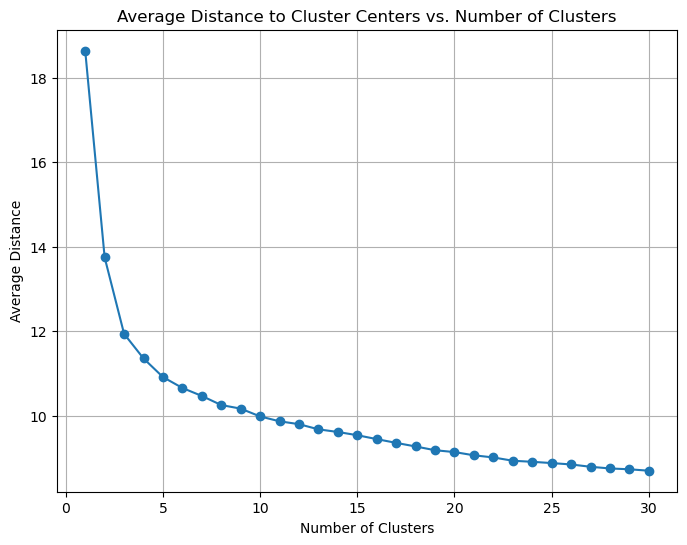

In [128]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(8, 6))
plt.plot(range(1, 31), average_distances, marker='o')
plt.title("Average Distance to Cluster Centers vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Distance")
plt.grid(True)
plt.show()

In [129]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

final_kmeans = KMeans(n_clusters=5, random_state=22)
demographics_prediction = final_kmeans.fit_predict(demographics_pca)
demographics_prediction

array([3, 3, 4, ..., 3, 3, 1])

### Discussion 3.1: Apply Clustering to General Population

Using Elbow method, I have decided to segment the population into 5 clusters, as increasing the number of clusters after 5 doesn't appear to drop the average distance between clusters datapoints a lot. 

In sklearn, the score() method for the KMeans class returns the negative inertia. Inertia is the sum of squared distances between the points and their assigned cluster centers. A lower inertia indicates a better clustering solution, as it means the points are closer to their cluster centers, so the average distance was calculted by taking the negative of the score then applying the square root to it. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [132]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [133]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_preprocessed = clean_data(customers)
customers_preprocessed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_nan,Decade,Movement,CAMEO_Wealth,CAMEO_LifeStage,LP_Income,LP_LifeStage,LP_Income_Grob,LP_LifeStage_Grob
0,4.0,1,5,1,5,1,2,2,1,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,7.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1.0,1.0,3.0,3.0,3.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,2.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1950.0,1.0,3.0,4.0,5.0,1.0,1.0,2.0
3,4.0,1,5,1,5,2,1,2,0,2.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,1.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,1992.0,7.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.

In [134]:
customers_preprocessed.isna().sum()

ALTERSKATEGORIE_GROB       223
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP                2189
RETOURTYP_BK_S            2898
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
VERS_TYP                  2189
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE           0
W_KEIT_KIND_HH            7624
WOHNDAUER_2008               0
ANZ_HAUSHALTE_AKTIV       2295
ANZ_HH_T

In [135]:
customers_preprocessed[numeric_features.tolist()] = impute_median.transform(customers_preprocessed[numeric_features.tolist()])
customers_preprocessed[ordinal_features.tolist() + new_mixed_features + ['VERS_TYP', 'PLZ8_BAUMAX']] = impute_mode.transform(customers_preprocessed[ordinal_features.tolist() + new_mixed_features + ['VERS_TYP', 'PLZ8_BAUMAX']])
customers_preprocessed[numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']] = scaler.transform(customers_preprocessed[numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']])

In [137]:
customers_preprocessed.isna().sum()

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
VERS_TYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
WOHNDAUER_2008           0
ANZ_HAUSHALTE_AKTIV      0
ANZ_HH_TITEL             0
KONSUMNAEHE              0
MIN_GEBAEUDEJAHR         0
WOHNLAGE                 0
KBA05_ANTG1              0
K

In [141]:
customers_pca = pca.transform(customers_preprocessed)

In [143]:
customers_prediction = final_kmeans.predict(customers_pca)
customers_prediction

array([1, 1, 1, ..., 1, 4, 1])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [147]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# For general population
general_population_cluster_proportions = pd.Series(demographics_prediction).value_counts(normalize=True)

# For customer dataset
customer_cluster_proportions = pd.Series(customers_prediction).value_counts(normalize=True)

# Print the proportions
print("General Population Cluster Proportions:")
print(general_population_cluster_proportions)

print("\nCustomer Dataset Cluster Proportions:")
print(customer_cluster_proportions)

General Population Cluster Proportions:
3    0.315419
4    0.220300
0    0.189786
2    0.144922
1    0.129573
Name: proportion, dtype: float64

Customer Dataset Cluster Proportions:
1    0.447441
2    0.237785
4    0.178707
0    0.087180
3    0.048887
Name: proportion, dtype: float64


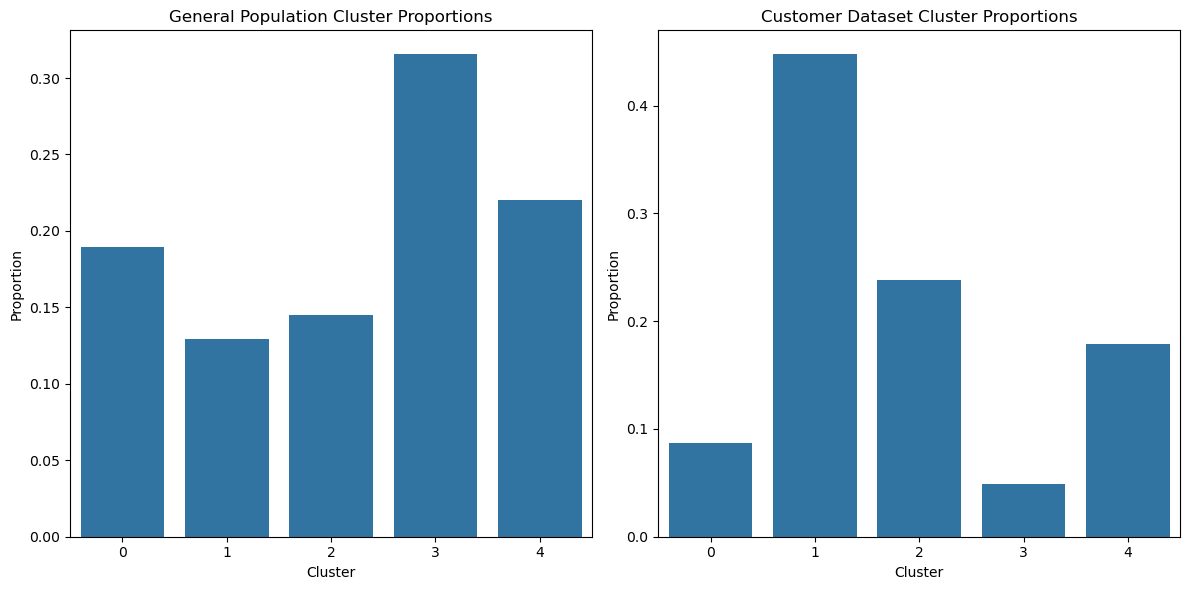

In [149]:
# Convert the proportions to DataFrame for easy plotting
df_general_population = general_population_cluster_proportions.reset_index()
df_general_population.columns = ['Cluster', 'Proportion']
df_customer = customer_cluster_proportions.reset_index()
df_customer.columns = ['Cluster', 'Proportion']

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot for General Population
plt.subplot(1, 2, 1)
sns.barplot(data=df_general_population, x='Cluster', y='Proportion')
plt.title('General Population Cluster Proportions')

# Plot for Customer Dataset
plt.subplot(1, 2, 2)
sns.barplot(data=df_customer, x='Cluster', y='Proportion')
plt.title('Customer Dataset Cluster Proportions')

plt.tight_layout()
plt.show()

In [266]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# cluster 1 seems to be overrepresented in the customers data compared to the general population

cluster_centroids_pca = final_kmeans.cluster_centers_

# Reverse PCA transformation
centroids_original_space = pca.inverse_transform(cluster_centroids_pca[1, :].reshape(1, 36))
df_centroids_scaled = pd.DataFrame(centroids_original_space, columns=demographics_cleaned.columns)

# Reverse scaling transformation
centroids_original_space_unscaled = scaler.inverse_transform(df_centroids_scaled[numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']])

df_centroids_unscaled = pd.DataFrame(centroids_original_space_unscaled, columns=[numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']])

df_centroids = pd.concat([df_centroids_scaled.drop(columns=numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']), df_centroids_unscaled], axis=1)
df_centroids

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_nan,Decade,Movement,CAMEO_Wealth,CAMEO_LifeStage,LP_Income,LP_LifeStage,LP_Income_Grob,LP_LifeStage_Grob,"(ANZ_PERSONEN,)","(ANZ_TITEL,)","(ANZ_HAUSHALTE_AKTIV,)","(ANZ_HH_TITEL,)","(MIN_GEBAEUDEJAHR,)","(KBA13_ANZAHL_PKW,)","(VERS_TYP,)","(PLZ8_BAUMAX,)"
0,3.714901,1.520503,3.808057,1.066472,4.940154,1.478649,1.409985,3.746278,0.268545,1.86506,4.232487,3.960861,3.41485,2.619649,3.061934,4.517616,5.906482,5.600393,3.152539,2.698193,4.616546,4.153828,4.218132,2.625983,2.487057,4.255158,5.53491,8.566944,3.070645,3.910677,1.57473,1.193426,0.587894,0.298564,3.175806,4.150437,3.96893,4.580367,3.802009,2.696505,3.012916,1.905119,4.477237,2.275304,2.808331,1.597641,0.675565,3.590289,3.38235,3.224381,5.291417,3.101585,0.237856,0.400104,0.088693,0.117892,0.088988,0.060373,0.006094,0.007197,0.329954,-0.016361,-0.012044,0.305292,0.385962,0.038515,0.005575,0.118615,0.130635,0.126388,0.052864,0.11374,0.118653,0.009247,0.141166,0.052076,0.086433,0.006094,0.531896,0.217989,-0.002117,-0.003096,-0.001037,-0.005556,-0.007502,0.00103,0.007797,0.155154,0.047866,0.057577,0.531896,0.217989,-0.006251,-0.012029,0.210817,0.057577,0.322677,0.007854,0.127329,0.092313,-0.006482,0.032916,0.020208,0.005811,0.191333,0.199947,0.006094,0.330531,0.21316,0.053125,0.197144,0.199947,0.006094,0.938692,0.036408,0.012178,0.012722,0.172979,0.262132,0.178567,0.367451,0.018871,0.162821,0.015852,0.738318,0.076947,-0.052084,0.058146,0.604833,0.013156,0.196647,0.001967,0.000001,0.001135,0.18226,0.236839,0.763161,0.061595,0.107364,0.113741,0.115305,0.063194,0.171089,0.087755,0.181658,0.094193,0.004106,1947.258723,0.268545,3.226505,3.340858,1.784744,2.477046,0.430366,1.

In [255]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# cluster 3 seems to be overrepresented in the customers data compared to the general population

# Reverse PCA transformation
centroids_original_space = pca.inverse_transform(cluster_centroids_pca[3, :].reshape(1, 36))
df_centroids_scaled = pd.DataFrame(centroids_original_space, columns=demographics_cleaned.columns)

# Reverse scaling transformation
centroids_original_space_unscaled = scaler.inverse_transform(df_centroids_scaled[numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']])

df_centroids_unscaled = pd.DataFrame(centroids_original_space_unscaled, columns=[numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']])

df_centroids = pd.concat([df_centroids_scaled.drop(columns=numeric_features.tolist() + ['VERS_TYP', 'PLZ8_BAUMAX']), df_centroids_unscaled], axis=1)
df_centroids

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GFK_URLAUBERTYP_nan,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_FEIN_nan,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_FAMILIE_GROB_nan,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_nan,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,LP_STATUS_GROB_nan,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,NATIONALITAET_KZ_nan,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SHOPPER_TYP_nan,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_nan,Decade,Movement,CAMEO_Wealth,CAMEO_LifeStage,LP_Income,LP_LifeStage,LP_Income_Grob,LP_LifeStage_Grob,"(ANZ_PERSONEN,)","(ANZ_TITEL,)","(ANZ_HAUSHALTE_AKTIV,)","(ANZ_HH_TITEL,)","(MIN_GEBAEUDEJAHR,)","(KBA13_ANZAHL_PKW,)","(VERS_TYP,)","(PLZ8_BAUMAX,)"
0,1.989063,1.554918,1.927631,4.305898,2.151048,4.184522,4.014959,3.370767,0.183972,2.343355,2.529305,4.370495,4.762165,5.327623,4.436885,3.953118,3.448187,3.65921,4.852838,4.822106,4.329562,4.473845,4.25968,5.426078,4.756391,4.672944,4.090717,7.374254,2.921387,4.045369,1.302967,1.229294,0.668484,0.34424,3.012085,4.078948,4.057031,4.435588,3.689918,2.751622,2.724418,3.37576,4.660669,2.172302,2.864919,1.685964,0.755058,3.636867,3.318486,3.198479,5.420648,3.136132,0.04015,0.031806,0.234373,0.323157,0.194768,0.172,0.003746,0.601071,-0.000718,0.077481,0.156147,0.010125,0.155894,0.073705,0.065946,0.042342,0.046205,0.056624,0.01614,0.013916,0.086744,0.122349,0.123569,0.1133,0.235413,0.003746,0.508851,0.084208,0.01009,0.020439,0.022453,0.017225,0.030037,0.034416,0.017309,0.161782,0.059463,0.033727,0.508851,0.084208,0.052982,0.081678,0.238554,0.033727,0.182239,0.366143,0.05347,0.117085,0.094496,0.028527,0.005369,0.019893,0.059617,0.069414,0.003746,0.548382,0.265051,0.033896,0.07951,0.069414,0.003746,0.731264,0.108538,0.073426,0.086772,0.209741,0.312313,0.247749,0.137586,0.092611,0.150765,0.041742,0.078361,0.423017,0.257255,0.04886,0.535689,0.00237,0.244758,0.000623,3.090002e-07,0.000432,0.216128,0.204276,0.795724,0.038794,0.09423,0.099318,0.12313,0.070297,0.1233,0.101599,0.177588,0.167247,0.004497,1989.998145,0.183972,3.385862,2.652728,0.839479,0.798055,0.169268,1.103787,1.753555,

### Discussion 3.3: Compare Customer Data to Demographics Data

1. Overrepresented Cluster (Cluster 1)
This group consists primarily of:
- Middle-aged or older individuals.
- Likely higher-income earners.
- More financially engaged, with a tendency toward investment and homeownership.
- More likely to live in larger households or suburban homes.
- Higher car ownership, indicating suburban or rural residency.
- Possibly more environmentally conscious (depending on GREEN_AVANTGARDE value).
- More individualistic in financial and insurance behavior.

In short, the overrepresented group consists of wealthier, financially active, middle-aged or older individuals living in larger homes with more cars.

2. Underrepresented Clusters (Cluster 3)
Cluster 3 being highly underrepresented may suggest that this group consists primarily of:

- Young individuals (under 30 years old).
- Slightly more males than females.
- Low-income earners.
- Likely to be single or in small households.
- Financially cautious, preferring to save rather than invest.
- Less engaged in environmental movements.
- More likely to live in smaller residential buildings (3-5 family homes).
- Moderate car ownership, likely urban dwellers.
- Socially safety-driven when it comes to insurance.
  
This means that young, low-income individuals, especially those who are financially cautious and not strongly engaged in green movements, are underrepresented in the customer data compared to the general population.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.